# Reference
- https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929 Collaborative Filtering by Embedding
- http://surpriselib.com/

# Step 0: Import Library

In [1]:
import pandas as pd
import numpy as np

# Step 1: Load & Explore data

In [2]:
dataset = pd.read_csv('./Data/ratings.dat',
                         delimiter='::', engine='python', header=None,
                         names=['UserID', 'MovieID', 'Rating', 'timestamps'])
dataset.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
len(dataset)

1000209

In [4]:
len(dataset.UserID.unique()), len(dataset.MovieID.unique())

(6040, 3706)

# Step 2: Check if there is any missing data

In [5]:
dataset.isna().sum()

UserID        0
MovieID       0
Rating        0
timestamps    0
dtype: int64

# Step 3: Drop Timestamp

In [6]:
dataset.drop('timestamps', axis=1, inplace=True)
dataset.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


# Step 4: Exploratory Data Analysis

### 4.1 Number of movies and users

In [7]:
n_movies = dataset['MovieID'].nunique()
n_users = dataset['UserID'].nunique()
print(f'Number of unique movies: {n_movies}')
print(f'Number of unique users: {n_users}')

Number of unique movies: 3706
Number of unique users: 6040


### 4.2 Check Sparsity of the Data

In [8]:
available_ratings = dataset['Rating'].count()
total_ratings = n_movies*n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings) * 100

print(f'Number of Available Ratings: {available_ratings}')
print(f'Number of Missing Ratings: {missing_ratings}')
print(f'Number of Total Ratings: {total_ratings}', '\n')
print(f'Sparsity: {sparsity}')

Number of Available Ratings: 1000209
Number of Missing Ratings: 21384031
Number of Total Ratings: 22384240 

Sparsity: 95.53163743776871


### 4.3 Explore the Distribution of Rating

<AxesSubplot:>

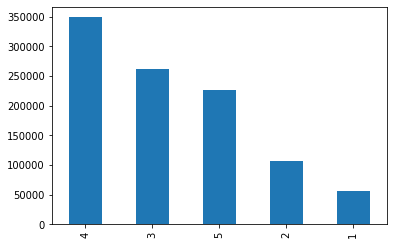

In [9]:
dataset['Rating'].value_counts().plot(kind='bar')

# Step 5: Dimensionality Reduction
To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

### 5.1 Filter movies with less than 3 ratings

In [10]:
filter_movies = dataset['MovieID'].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()
len(filter_movies)

3461

### 5.2 Filter users with less than 3 movies rated

In [11]:
filter_users = dataset['UserID'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()
len(filter_users)

6040

### 5.3 Remove rarely rated movies and rarely rating users

In [12]:
#5.3-Remove-rarely-rated-movies-and-rarely-rating-usersprint(f'Original shape: {dataset.shape}')
dataset = dataset[(dataset['MovieID'].isin(filter_movies)) & (dataset['UserID'].isin(filter_users))]
print(f'New shape: {dataset.shape}')

New shape: (999791, 3)


# Step 6: We assign a unique number between (0, #users) to each user and do the same for movies and store the mapping function

In [13]:
u_d = dict(enumerate(dataset.UserID.astype('category').cat.categories))
u_d = {v: k for k, v in u_d.items()}
m_d = dict(enumerate(dataset.MovieID.astype('category').cat.categories))
m_d = {v: k for k, v in m_d.items()}

In [14]:
dataset.UserID = dataset.UserID.astype('category').cat.codes.values
dataset.MovieID = dataset.MovieID.astype('category').cat.codes.values

In [15]:
dataset.tail()

,UserID,MovieID,Rating
1000204,6039,934,1
1000205,6039,937,5
1000206,6039,528,5
1000207,6039,939,4
1000208,6039,940,4


# Step 7: Create user-item matrix

In [16]:
matrix = dataset.pivot_table(index='UserID', columns='MovieID', values='Rating')
matrix.head()

MovieID,0,1,2,3,4,5,6,7,8,9,...,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 8: Data Normalization - for consine similarity of user

In [17]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

MovieID,0,1,2,3,4,5,6,7,8,9,...,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460
UserID,,,,,,,,,,,,,,,,,,,,,
0,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-1.146465,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 9: Calculate Similarity Score for User

In [18]:
user_similarity = matrix_norm.T.corr()
user_similarity.head()

UserID,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
UserID,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.416667,-0.332182,0.333333,-0.172516,0.219956,NaN,-0.583333,3.305715e-01,-0.057363,...,-0.160128,7.559289e-01,1.000000,NaN,0.381246,-0.201132,-4.517540e-01,NaN,0.056857,-0.043519
1,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,9.083405e-02,0.301309,NaN,0.390907,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
2,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,8.012345e-18,0.009305,...,-0.395285,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,2.485765e-17,0.500000,0.309277,-0.395285
3,0.333333,-0.118678,0.840168,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-0.645497,-4.532467e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
4,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-3.345621e-17,-0.023582,...,0.260875,7.071068e-01,0.116775,0.5,0.539112,0.160690,-9.713482e-02,-0.928571,1.000000,0.308273


# Step 10: Split the data into train, test & validation set for cross validation

### 10.1 Prepare Training Data (70%)

In [19]:
from sklearn.model_selection import train_test_split
train, temp_test = train_test_split(dataset, test_size=0.3)

In [20]:
train.shape

(699853, 3)

In [21]:
temp_test.shape

(299938, 3)

### 10.2 Prepare Testing and Validation Data (15% & 15%)

In [22]:
test, validate = train_test_split(temp_test, test_size=0.5)

In [23]:
test.shape

(149969, 3)

In [24]:
validate.shape

(149969, 3)

# Step 11: Create Model

In [25]:
from tensorflow.keras.layers import Embedding, Reshape, Dot, Dropout, Dense,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import metrics
import tensorflow as tf

In [26]:
user_num = len(dataset.UserID.unique())
item_num = len(dataset.MovieID.unique())

embed_dim = 5

# Embedding layer enables us to convert each Movie into a fixed length vector of defined size
movie_input = Input(shape=[1]) # movie rating
movie_embedding = Embedding(item_num, embed_dim)(movie_input) #6040 x 5 x 1
movie_vec = Reshape((embed_dim,))(movie_embedding) # Use Reshape to get the vector

# Embedding layer enables us to convert each User into a fixed length vector of defined size
user_input = Input(shape=[1])
user_embedding = Embedding(user_num, embed_dim)(user_input) # 3672 x 5 x 1
user_vec = Reshape((embed_dim,))(user_embedding) # Use Reshape to get the vector

dot = Dot(axes = 1)([movie_vec,user_vec])

model = Model([user_input, movie_input], dot) # the model is a dot product of user_input and movie_input

#MSE
model.compile('adam', 'mean_squared_error')

#MAPE
#mape = tf.keras.losses.MeanAbsolutePercentageError()
#model.compile('adam', mape)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         17305       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 5)         30200       ['input_2[0][0]']                
                                                                                              

In [28]:
history = model.fit([train.UserID, train.MovieID], train.Rating, epochs=20,
                    validation_data=([test.UserID,test.MovieID], test.Rating))

Epoch 1/20
21871/21871 [==============================] - 113s 5ms/step - loss: 4.8907 - val_loss: 1.1192
Epoch 2/20
21871/21871 [==============================] - 112s 5ms/step - loss: 0.9515 - val_loss: 0.8944
Epoch 3/20
21871/21871 [==============================] - 106s 5ms/step - loss: 0.8736 - val_loss: 0.8736
Epoch 4/20
21871/21871 [==============================] - 101s 5ms/step - loss: 0.8612 - val_loss: 0.8657
Epoch 5/20
21871/21871 [==============================] - 95s 4ms/step - loss: 0.8520 - val_loss: 0.8575
Epoch 6/20
21871/21871 [==============================] - 106s 5ms/step - loss: 0.8389 - val_loss: 0.8418
Epoch 7/20
21871/21871 [==============================] - 101s 5ms/step - loss: 0.8188 - val_loss: 0.8243
Epoch 8/20
21871/21871 [==============================] - 97s 4ms/step - loss: 0.7995 - val_loss: 0.8129
Epoch 9/20
21871/21871 [==============================] - 104s 5ms/step - loss: 0.7847 - val_loss: 0.8021
Epoch 10/20
21871/21871 [=======================

# Step 12: Testing by test dataset & do Prediction

In [29]:
def get_value(k,d):
    # meet unknow user or movie, just assign a random user
    if k not in d.keys():
        return 0
    return d[k]

Mapping using the same dictionary

In [30]:
validate['UserID'] = validate['UserID'].apply(get_value, d = u_d) # map the userID in testing will be existed in traing
validate['MovieID'] = validate['MovieID'].apply(get_value, d = m_d) # map the movieID in testing will be existed in traing

In [31]:
validate.head()

,UserID,MovieID,Rating
291573,1735,1277,4
613093,3714,514,2
794246,4746,2095,4
355407,2077,603,3
283505,1695,2138,4


In [32]:
prediction = model.predict([validate['UserID'], validate['MovieID']])
res = validate
res['Rating'] = prediction

4687/4687 [==============================] - 5s 947us/step


In [33]:
res.head()

,UserID,MovieID,Rating
291573,1735,1277,1.171157
613093,3714,514,3.532908
794246,4746,2095,3.471993
355407,2077,603,2.605485
283505,1695,2138,2.237606


In [34]:
res.to_csv('Output_User.csv', columns = ['UserID','MovieID','Rating'] ,index  = False)